$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
$$

In [1]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import numpy as np;

# ipython
import IPython;

# python
import os;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100,
                         (x.size[1]*percent)//100),
                        PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = False;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise("Error:  Graphical model image %s not found." 
                  + "You may need to set RENDER_PGMS=True.");
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning
## Lecture 14:  Exponential Families & Bayesian Networks
* Instructor:  **Jacob Abernethy**
* Date:  March 9, 2016

*Lecture Exposition Credit:*  Benjamin Bray & Valliappa Chockalingam

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models).  2009.
- **[Hero 2008]** Hero, Alfred O..  [*Statistical Methods for Signal Processing*](http://web.eecs.umich.edu/~hero/Preprints/main_564_08_new.pdf).  2008.
- **[Blei 2011]** Blei, David. [*Notes on Exponential Families*](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/exponential-families.pdf).  2011.
- **[Jordan 2010]** Jordan, Michael I..  [*The Exponential Family:  Basics*](http://www.cs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf).  2008.

## Outline

- Exponential Families
    - Sufficient Statistics & Pitman-Koopman-Darmois Theorem
    - Mean and natural parameters
    - Maximum Likelihood estimation
- Probabilistic Graphical Models
    - Directed Models (Bayesian Networks)
    - Conditional Independence & Factorization
    - Examples

# Exponential Families

> Uses material from **[MLAPP]** §9.2 and **[Hero 2008]** §3.5, §4.4.2

### Exponential Family: Introduction

We have seen many distributions.
* Bernoulli
* Gaussian
* Exponential
* Gamma 
    
Many of these belong to a more general class called the **exponential family**.

### Exponential Family:  Introduction

Why do we care?
* only family of distributions with finite-dimensional **sufficient statistics**
* only family of distributions for which **conjugate priors** exist
* makes the least set of assumptions subject to some user-chosen constraints (**Maximum Entropy**)
* core of generalized linear models and **variational inference**

### Sufficient Statistics

**Recall:** A **statistic** $T(\D)$ is a function of the observed data $\D$.
- Mean, $T(x_1, \dots, x_n) = \frac{1}{n}\sum_{k=1}^n x_k$
- Variance, maximum, mode, etc.

### Sufficient Statistics:  Definition

Suppose we have a model $P$ with parameters $\theta$.  Then,

> A statistic $T(\D)$ is **sufficient** for $\theta$ if no other statistic calculated from the same sample provides any additional information about the parameter.

That is, if $T(\D_1) = T(\D_2)$, our estimate of $\theta$ given $\D_1$ or $\D_2$ will be the same.
- Mathematically, $P(\theta | T(\D), \D) = P(\theta | T(\D))$ independently of $\D$

### Sufficient Statistics:  Example

Suppose $X \sim \mathcal{N}(\mu, \sigma^2)$ and we observe $\mathcal{D} = (x_1, \dots, x_n)$.  Let
- $\hat\mu$ be the sample mean
- $\hat{\sigma}^2$ be the sample variance

Then $T(\mathcal{D}) = (\hat\mu, \hat{\sigma}^2)$ is sufficient for $\theta=(\mu, \sigma^2)$.
- Two samples $\D_1$ and $\D_2$ with the same mean and variance give the same estimate of $\theta$

<span style="color:gray">(we are sweeping some details under the rug)</span>

### Exponential Family:  Definition

$p(x | \theta)$ has **exponential family form** if:
$$
\begin{align}
p(x | \theta)
&= \frac{1}{Z(\theta)} h(x) \exp\left[ \eta(\theta)^T \phi(x) \right] \\
&= h(x) \exp\left[ \eta(\theta)^T \phi(x) - A(\theta) \right]
\end{align}
$$

- $Z(\theta)$ is the **partition function** for normalization
- $A(\theta) = \log Z(\theta)$ is the **log partition function**
- $\phi(x) \in \R^d$ is a vector of **sufficient statistics**
- $\eta(\theta)$ maps $\theta$ to a set of **natural parameters**
- $h(x)$ is a scaling constant, usually $h(x)=1$

### Example:  Bernoulli

The Bernoulli distribution can be written as
$$
\begin{align}
\mathrm{Ber}(x | \mu)
&= \mu^x (1-\mu)^{1-x} \\
&= \exp\left[ x \log \mu + (1-x) \log (1-\mu) \right] \\
&= \exp\left[ \eta(\mu)^T \phi(x) \right]
\end{align}
$$

where $\eta(\mu) = (\log\mu, \log(1-\mu))$ and $\phi(x) = (x, 1-x)$
- There is a linear dependence between features $\phi(x)$
- This representation is **overcomplete**
- $\eta$ is not uniquely determined

### Example:  Bernoulli

Instead, we can find a **minimal** parameterization:
$$
\begin{align}
\mathrm{Ber}(x | \mu) 
&= (1-\mu) \exp\left[ x \log\frac{\mu}{1-\mu} \right]
\end{align}
$$

This gives **natural parameters** $\eta = \log \frac{\mu}{1-\mu}$.
- Now, $\eta$ is unique

### Other Examples

Exponential Family Distributions:
- Multivariate normal
- Exponential
- Dirichlet

Non-examples:
- Student t-distribution can't be written in exponential form
- Uniform distribution support depends on the parameters $\theta$

### Log-Partition Function

Derivatives of the **log-partition function** $A(\theta)$ yield **cumulants** of the sufficient statistics *(Exercise!)*
- $\nabla_\theta A(\theta) = E[\phi(x)]$
- $\nabla^2_\theta A(\theta) = \text{Cov}[ \phi(x) ]$

This guarantees that $A(\theta)$ is convex!
- Its Hessian is the covariance matrix of $X$, which is positive-definite.
- Later, this will guarantee a unique global maximum of the likelihood! 

#### <span style="color:gray">Proof of Convexity: First Derivative</span>

$$
\begin{align}
\frac{dA}{d\theta}
&= \frac{d}{d\theta} \left[ \log \int exp(\theta\phi(x))h(x)dx \right] \\
&= \frac{\frac{d}{d\theta} \int exp(\theta\phi(x))h(x)dx)}{\int exp(\theta\phi(x))h(x)dx)} \\
&= \frac{\int \phi(x)exp(\theta\phi(x))h(x)dx}{exp(A(\theta))} \\
&= \int \phi(x) \exp[\theta\phi(x)-A(\theta)] h(x) dx \\
&= \int \phi(x) p(x) dx \\
&= E[\phi(x)]
\end{align}
$$

#### <span style="color:gray">Proof of Convexity: Second Derivative</span>

$$
\begin{align}
\frac{d^2A}{d\theta^2}
& = \int \phi(x)\exp[\theta \phi(x) - A(\theta)] h(x) (\phi(x) - A'(\theta)) dx \\
& = \int \phi(x) p(x) (\phi(x) - A'(\theta))dx \\
& = \int \phi^2(x) p(X) dx - A'(\theta) \int \phi(x)p(x)dx \\
& = E[\phi^2(x)] - E[\phi(x)]^2  \hspace{2em}   (\because A'(\theta) = E[\phi(x)])  \\ 
& = Var[\phi(x)]
\end{align}
$$

#### <span style="color:gray">Proof of Convexity: Second Derivative</span>

For multi-variate case, we have 

$$ \frac{\partial^2A}{\partial\theta_i \partial\theta_j} = E[\phi_i(x)\phi_j(x)] - E[\phi_i(x)] E[\phi_j(x)]$$

and hence,
$$ \nabla^2A(\theta) = Cov[\phi(x)] $$

Since covariance is positive definite, we have $A(\theta)$ convex as required.

### Exponential Family:  Likelihood

For data $\D = (x_1, \dots, x_N)$, the likelihood is
$$
p(\D|\theta)
= \left[ \prod_{k=1}^N h(x_k) \right] Z(\theta)^{-N} \exp\left[ \eta(\theta)^T \left(\sum_{k=1}^N \phi(x_k) \right) \right]
$$

The sufficient statistics are now $\phi(\D) = \sum_{k=1}^N \phi(x)$.
- **Bernoulli:**  $\phi = \# Heads$
- **Normal:** $\phi = [ \sum_k x_k, \sum_k x_k^2 ]$

### Pitman-Koopman-Darmois Theorem

> Among families of distributions $P(x | \theta)$ whose support does not vary with the parameter $\theta$, only in exponential families is there a sufficient statistic $T(x_1,\dots,x_N)$ whose dimension remains bounded as the sample size $N$ increases.

### Exponential Family:  MLE

For natural parameters $\theta$ and data $\D = (x_1, \dots, x_N)$, 
$$
\log p(\D|\theta) = \theta^T \phi(\D) - N A(\theta)
$$

Since $-A(\theta)$ is concave and $\theta^T\phi(\D)$ linear,
- the log-likelihood is concave
- under many conditions, there is a unique global maximum!
> Strict convexity of the log-partition function requires that we are working with a "regular exponential family". More on this can be found in [These Notes](http://pages.cs.wisc.edu/~jerryzhu/cs731/expfamily.pdf). 

### Exponential Family:  MLE

To find the maximum, recall $\nabla_\theta A(\theta) = E_\theta[\phi(x)]$, so
\begin{align*}
\nabla_\theta \log p(\D | \theta) & =
\nabla_\theta(\theta^T \phi(\D) - N A(\theta)) \\
& = \phi(\D) - N E_\theta[\phi(X)] = 0
\end{align*}
Which gives
$$E_\theta[\phi(X)] = \frac{\phi(\D)}{N} = \frac{1}{N} \sum_{k=1}^N \phi(x_k)$$

At the MLE $\hat\theta_{MLE}$, the empirical average of sufficient statistics equals their expected value.
- this is called **moment matching**

### Exponential Family:  MLE

As an example, consider the Bernoulli distribution
- Sufficient statistic $N$, $\phi(\D) = \# Heads$

$$
\hat\mu_{MLE} = \frac{\# Heads}{N}
$$

### Bayes for Exponential Family

Exact Bayesian analysis is considerably simplified if the prior is **conjugate** to the likelihood.
- Simply, this means that prior $p(\theta)$ has the same form as the posterior $p(\theta|\mathcal{D})$.

This requires likelihood to have finite sufficient statistics
* Exponential family to the rescue!

**Note**: We will release some notes on cojugate priors + exponential families. It's hard to learn from slides and needs a bit more description. 

### Likelihood for exponential family

Likelihood: 
$$ p(\mathcal{D}|\theta) \propto g(\theta)^N \exp[\eta(\theta)^T s_N]\\
s_N = \sum_{i=1}^{N}\phi(x_i)$$

In terms of canonical parameters:
$$ p(\mathcal{D}|\eta) \propto \exp[N\eta^T \bar{s} -N A(\eta)] \\
\bar s = \frac{1}{N}s_N $$

### Conjugate prior for exponential family

* The prior and posterior for an exponential family involve two parameters, $\tau$ and $\nu$, initially set to $\tau_0, \nu_0$

$$ p(\theta| \nu_0, \tau_0) \propto g(\theta)^{\nu_0} \exp[\eta(\theta)^T \tau_0] $$

* Denote $ \tau_0 = \nu_0 \bar{\tau}_0$ to separate out the size of the **prior pseudo-data**, $\nu_0$ , from the mean of the sufficient statistics on this pseudo-data, $\tau_0$ . Hence,

$$ p(\theta| \nu_0, \bar \tau_0) \propto \exp[\nu_0\eta^T \bar \tau_0  - \nu_0 A(\eta)] $$

* Think of $\tau_0$ as a "guess" of the future sufficient statistics, and $\nu_0$ as the strength of this guess

### Prior:  Example

$$
\begin{align}
p(\theta| \nu_0, \tau_0) 
&\propto (1-\theta)^{\nu_0} \exp[\tau_0\log(\frac{\theta}{1-\theta})] \\
&= \theta^{\tau_0}(1-\theta)^{\nu_0 - \tau_0}
\end{align}
$$

Define $\alpha = \tau_0 +1 $ and $\beta = \nu_0 - \tau_0 +1$ to see that this is a **beta distribution**.

### Posterior

Posterior: 
$$ p(\theta|\mathcal{D}) = p(\theta|\nu_N, \tau_N) = p(\theta| \nu_0 +N, \tau_0 +s_N) $$

Note that we obtain **hyper-parameters** by adding. Hence,

$$ \begin{align}
p(\eta|\mathcal{D})
&\propto \exp[\eta^T (\nu_0 \bar\tau_0 + N \bar s) - (\nu_0 + N) A(\eta) ] \\
&= p(\eta|\nu_0 + N, \frac{\nu_0 \bar\tau_0 + N \bar s}{\nu_0 + N})
\end{align}$$
where $\bar s = \frac 1 N \sum_{i=1}^{N}\phi(x_i)$.

* *posterior hyper-parameters are a convex combination of the prior mean hyper-parameters and the average of the sufficient statistics.*

## Break time!

<img src="images/122_yawn_cat_gifs.gif"/>

# Probabilistic Graphical Models

> Uses material from **[MLAPP]** §10.1, 10.2 and **[Koller & Friedman 2009]**.

> "I basically know of two principles for treating complicated systems in simple ways:  the first is the principle of modularity and the second is the principle of abstraction.  I am an apologist for computational probability in machine learning because I believe that probability theory implements these two principles in deep and intriguing ways &mdash; nameley through factorization and through averaging.  Exploiting these two mechanisms as fully as possible seems to me to be the way forward in machine learning" &emsp;&ndash; Michael Jordan (qtd. in MLAPP)

### Graphical Models:  Motivation

Suppose we observe multiple correlated variables $x=(x_1, \dots, x_n)$.
- Words in a document
- Pixels in an image

How can we compactly represent the **joint distribution** $p(x|\theta)$?
- How can we tractably *infer* one set of variables given another?
- How can we efficiently *learn* the parameters?

### Joint Probability Tables

One (bad) choice is to write down a **Joint Probability Table**.
- For $n$ binary variables, we must specify $2^n - 1$ probabilities!
- Expensive to store and manipulate
- Impossible to learn so many parameters
- Very hard to interpret!

> Can we be more concise?

### Motivating Example:  Coin Flips

What is the joint distribution of three independent coin flips?
- Explicitly specifying the JPT requires $2^3-1=7$ parameters.

Assuming independence, $P(X_1, X_2, X_3) = P(X_1)P(X_2)P(X_3)$
- Each marginal $P(X_k)$ only requires one parameter, the bias
- This gives a total of $3$ parameters, compared to $8$.

> Exploiting the **independence structure** of a joint distribution leads to more concise representations.

### Motivating Example:  Naive Bayes

In Naive Bayes, we assumed the features $X_1, \dots, X_N$ were independent given the class label $C$:
$$
P(x_1, \dots, x_N, c) = P(c) \prod_{k=1}^N P(x_k | c)
$$

This greatly simplified the learning procedure:
- Allowed us to look at each feature individually
- Only need to learn $O(CN)$ probabilities, for $C$ classes and $N$ features

### Conditional Independence

The key to efficiently representing large joint distributions is to make **conditional independence** assumptions of the form
$$
X \perp Y \mid Z
\iff
p(X,Y|Z) = p(X|Z)p(Y|Z)
$$

> Once $z$ is known, information about $x$ does not tell us any information about $y$ and vice versa.

An effective way to represent these assumptions is with a **graph**.

### Bayesian Networks:  Definition

A **Bayesian Network** $\mathcal{G}$ is a directed acyclic graph whose nodes represent random variables $X_1, \dots, X_n$.
- Let $\Parents_\G(X_k)$ denote the parents of $X_k$ in $\G$
- Let $\NonDesc_\G(X_k)$ denote the variables in $\G$ who are not descendants of $X_k$.

> Examples will come shortly...

### Bayesian Networks:  Local Independencies

Every Bayesian Network $\G$ encodes a set $\I_\ell(\G)$ of **local independence assumptions**:

> For each variable $X_k$, we have $(X_k \perp \NonDesc_\G(X_k) \mid \Parents_\G(X_k))$

Every node $X_k$ is conditionally independent of its nondescendants given its parents.


### Example:  Naive Bayes

The graphical model for Naive Bayes is shown below:
- $\Parents_\G(X_k) = \{ C \}$, $\NonDesc_\G(X_k) = \{ X_j \}_{j\neq k}$
- Therefore $X_j \perp X_k \mid C$ for any $j \neq k$

In [2]:
@pgm_render
def pgm_naive_bayes():
    pgm = daft.PGM([4,3], origin=[-2,0], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("c", r"$C$", -0.25, 2));
    pgm.add_node(daft.Node("x1", r"$X_1$", -1, 1));
    pgm.add_node(daft.Node("x2", r"$X_2$", -0.5, 1));
    pgm.add_node(daft.Node("dots", r"$\cdots$",  0, 1, plot_params={ 'ec' : 'none' }));
    pgm.add_node(daft.Node("xN", r"$X_N$",  0.5, 1));
    
    # edges
    pgm.add_edge("c", "x1", head_length=0.08);
    pgm.add_edge("c", "x2", head_length=0.08);
    pgm.add_edge("c", "xN", head_length=0.08);
    
    return pgm;

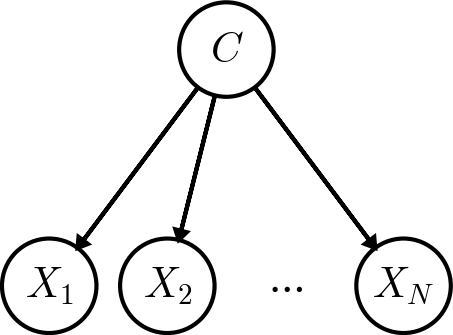

In [3]:
%%capture
pgm_naive_bayes("images/naive-bayes.png");

### Subtle Point:  Graphs & Distributions

A Bayesian network $\G$ over variables $X_1, \dots, X_N$ encodes a set of **conditional independencies**.
- Shows independence structure, nothing more.
- Does **not** tell us how to assign probabilities to a configuration $(x_1, \dots x_N)$ of the variables.

There are **many** distributions $P$ satisfying the independencies in $\G$.
- Many joint distributions share a common structure, which we exploit in algorithms.
- The distribution $P$ may satisfy other independencies **not** encoded in $\G$.

### Subtle Point:  Graphs & Distributions

If $P$ satisfies the independence assertions made by $\G$, we say that
- $\G$ is an **I-Map** for $P$
- or that $P$ **satisfies** $\G$.

Any distribution satisfying $\G$ shares common structure.
- We will exploit this structure in our algorithms
- This is what makes graphical models so **powerful**!

### Review:  Chain Rule for Probability

We can factorize any joint distribution via the **Chain Rule for Probability**:
$$
\begin{align}
P(X_1, \dots, X_N)
&= P(X_1) P(X_2, \dots, X_N | X_1) \\
&= P(X_1) P(X_2 | X_1) P(X_3, \dots, X_N | X_1, X_2) \\
&= \prod_{k=1}^N P(X_k | X_1, \dots, X_{k-1})
\end{align}
$$

> Here, the ordering of variables is arbitrary.  This works for any permutation.

### Bayesian Networks:  Topological Ordering

Every network $\G$ induces a **topological (partial) ordering** on its nodes:
> Parents assigned a lower index than their children

In [4]:
@pgm_render
def pgm_topological_order():
    pgm = daft.PGM([4, 4], origin=[-4, 0])

    # Nodes
    pgm.add_node(daft.Node("x1", r"$1$", -3.5, 2))
    pgm.add_node(daft.Node("x2", r"$2$", -2.5, 1.3))
    pgm.add_node(daft.Node("x3", r"$3$", -2.5, 2.7))
    pgm.add_node(daft.Node("x4", r"$4$", -1.5, 1.6))
    pgm.add_node(daft.Node("x5", r"$5$", -1.5, 2.3))
    pgm.add_node(daft.Node("x6", r"$6$", -0.5, 1.3))
    pgm.add_node(daft.Node("x7", r"$7$", -0.5, 2.7))

    # Add in the edges.
    pgm.add_edge("x1", "x4", head_length=0.08)
    pgm.add_edge("x1", "x5", head_length=0.08)
    pgm.add_edge("x2", "x4", head_length=0.08)
    pgm.add_edge("x3", "x4", head_length=0.08)
    pgm.add_edge("x3", "x5", head_length=0.08)
    pgm.add_edge("x4", "x6", head_length=0.08)
    pgm.add_edge("x4", "x7", head_length=0.08)
    pgm.add_edge("x5", "x7", head_length=0.08)
    
    return pgm;

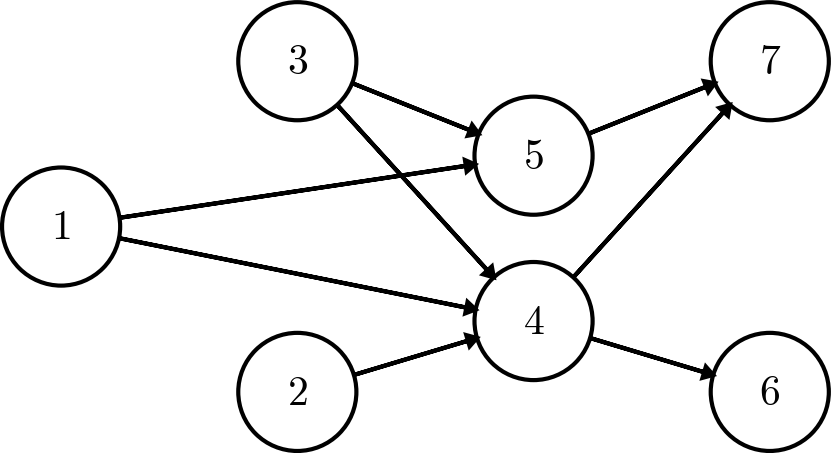

In [5]:
%%capture
pgm_topological_order("images/topological-order.png")

### Factorization Theorem:  Statement

**Theorem:** *(Koller & Friedman 3.1)* If $\G$ is an I-map for $P$, then $P$ **factorizes** as follows:
$$
P(X_1, \dots, X_N) = \prod_{k=1}^N P(X_k \mid \Parents_\G(X_k))
$$

> Let's prove it together!

### Factorization Theorem:  Proof

First, apply the chain rule to any topological ordering:
$$
P(X_1, \dots, X_N) = \prod_{k=1}^N P(X_k \mid X_1, \dots, X_{k-1})
$$

Consider one of the factors $P(X_k \mid X_1, \dots, X_{k-1})$. 

### Factorization Theorem:  Proof

Since our variables $X_1,\dots,X_N$ are in topological order,
- $\Parents_\G(X_k) \subseteq \{ X_1, \dots, X_{k-1} \}$
- None of $X_k$'s descendants can possibly lie in $\{ X_1, \dots, X_{k-1} \}$

Therefore, $\{ X_1, \dots, X_{k-1} \} = \Parents_\G(X_k) \cup \mathcal{Z}$
- for some $\mathcal{Z} \subseteq \NonDesc_\G(X_k)$.

### Factorization Theorem:  Proof

Recall the following property of conditional independence:
$$
( X \perp Y, W \mid Z ) \implies (X \perp Y \mid Z)
$$

Since $\G$ is an I-map for $P$ and $\mathcal{Z} \subseteq \NonDesc_\G(X_k)$, we have
$$\begin{align}
& (X_k \perp \NonDesc_\G(X_k) \mid \Parents_\G(X_k)) \\
\implies & (X_k \perp \mathcal{Z} \mid \Parents_\G(X_k))
\end{align}
$$

### Factorization Theorem:  Proof

We have just shown $(X_k \perp \mathcal{Z} \mid \Parents_\G(X_k))$, therefore
$$
P(X_k \mid X_1, \dots, X_{k-1}) = P(X_k \mid \Parents_\G(X_k))
$$

- Recall $\{ X_1, \dots, X_N \} = \Parents_\G(X_k) \cup \mathcal{Z}$.

> **Remember:**  $X_k$ is conditionally independent of its nondescendants given its parents!

### Factorization Theorem:  End of Proof

Applying this to every factor, we see that
$$
\begin{align}
P(X_1, \dots, X_N)
&= \prod_{k=1}^N P(X_k \mid X_1, \dots, X_{k-1}) \\
&= \prod_{k=1}^N P(X_k \mid \Parents_\G(X_k))
\end{align}
$$

### Factorization Theorem:  Consequences

We just proved that for any $P$ satisfying $\G$,
$$
P(X_1, \dots, X_N) = \prod_{k=1}^N P(X_k \mid \Parents_\G(X_k))
$$

It suffices to store **conditional probability tables** $P(X_k | \Parents_\G(X_k))$!
- Requires $O(N2^k)$ features if each node has $\leq k$ parents
- Substantially more compact than **JPTs** for $N$ large, $\G$ sparse
- We can also specify that a CPD is Gaussian, Dirichlet, etc.

### Example:  Fully Connected Graph

A **fully connected graph** makes no independence assumptions.
$$
P(A,B,C) = P(A) P(B|A) P(C|A,B)
$$

In [6]:
@pgm_render
def pgm_fully_connected_a():
    pgm = daft.PGM([4, 4], origin=[0, 0])

    # nodes
    pgm.add_node(daft.Node("a", r"$A$", 2, 3.5))
    pgm.add_node(daft.Node("b", r"$B$", 1.3, 2.5))
    pgm.add_node(daft.Node("c", r"$C$", 2.7, 2.5))

    # add in the edges
    pgm.add_edge("a", "b", head_length=0.08)
    pgm.add_edge("a", "c", head_length=0.08)
    pgm.add_edge("b", "c", head_length=0.08)
    
    return pgm;

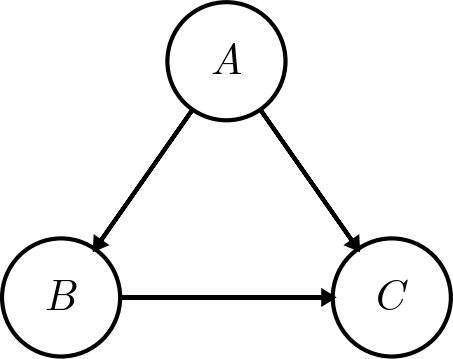

In [7]:
%%capture
pgm_fully_connected_a("images/fully-connected-a.png")

### Example:  Fully Connected Graph

There are many possible fully connected graphs:
$$
\begin{align}
P(A,B,C) 
&= P(A) P(B|A) P(C|A,B) \\
&= P(B) P(C|B) P(A|B,C)
\end{align}
$$

In [8]:
@pgm_render
def pgm_fully_connected_b():
    pgm = daft.PGM([8, 4], origin=[0, 0])

    # nodes
    pgm.add_node(daft.Node("a1", r"$A$", 2, 3.5))
    pgm.add_node(daft.Node("b1", r"$B$", 1.5, 2.8))
    pgm.add_node(daft.Node("c1", r"$C$", 2.5, 2.8))

    # add in the edges
    pgm.add_edge("a1", "b1", head_length=0.08)
    pgm.add_edge("a1", "c1", head_length=0.08)
    pgm.add_edge("b1", "c1", head_length=0.08)
    
    # nodes
    pgm.add_node(daft.Node("a2", r"$A$", 4, 3.5))
    pgm.add_node(daft.Node("b2", r"$B$", 3.5, 2.8))
    pgm.add_node(daft.Node("c2", r"$C$", 4.5, 2.8))

    # add in the edges
    pgm.add_edge("b2", "c2", head_length=0.08)
    pgm.add_edge("b2", "a2", head_length=0.08)
    pgm.add_edge("c2", "a2", head_length=0.08)
    
    return pgm;

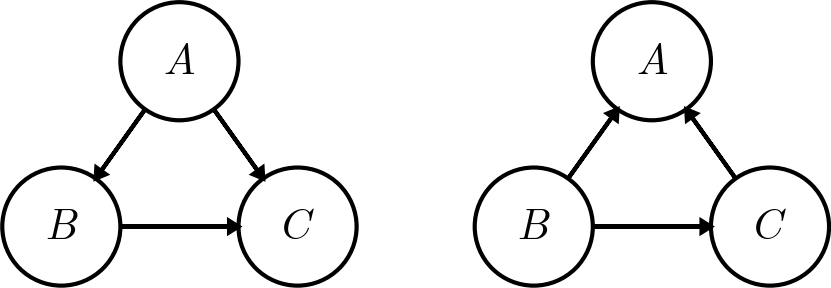

In [9]:
%%capture
pgm_fully_connected_b("images/fully-connected-b.png")

### Bayesian Networks & Causality

The fully-connected example brings up a crucial point:

> Directed edges do **not** necessarily represent causality.

Bayesian networks encode **independence assumptions** only.
- This representation is not unique.

### Example:  Markov Chain

State at time $t$ depends only on state at time $t-1$.
$$
P(X_0, X_1, \dots, X_N) = P(X_0) \prod_{t=1}^N P(X_t \mid X_{t-1})
$$

In [10]:
@pgm_render
def pgm_markov_chain():
    pgm = daft.PGM([6, 6], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("x1", r"$\mathbf{x}_n$", 2, 2.5))
    pgm.add_node(daft.Node("x2", r"$\mathbf{x}_2$", 3, 2.5))
    pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("xN", r"$\mathbf{x}_N$", 4.5, 2.5))

    # Add in the edges.
    pgm.add_edge("x1", "x2", head_length=0.08)
    pgm.add_edge("x2", "ellipsis", head_length=0.08)
    pgm.add_edge("ellipsis_end", "xN", head_length=0.08)
    
    return pgm;

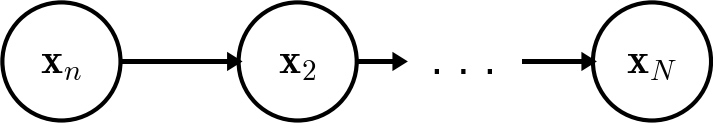

In [11]:
%%capture
pgm_markov_chain("images/markov-chain.png")

### Example:  Hidden Markov Model

Noisy observations $X_k$ generated from hidden Markov chain $Y_k$.
$$
P(\vec{X}, \vec{Y}) = P(Y_1) P(X_1 \mid Y_1) \prod_{k=2}^N \left(P(Y_k \mid Y_{k-1}) P(X_k \mid Y_k)\right)
$$

In [12]:
@pgm_render
def pgm_hmm():
    pgm = daft.PGM([7, 7], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("Y1", r"$Y_1$", 1, 3.5))
    pgm.add_node(daft.Node("Y2", r"$Y_2$", 2, 3.5))
    pgm.add_node(daft.Node("Y3", r"$\dots$", 3, 3.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("Y4", r"$Y_N$", 4, 3.5))

    pgm.add_node(daft.Node("x1", r"$X_1$", 1, 2.5, observed=True))
    pgm.add_node(daft.Node("x2", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("x3", r"$\dots$", 3, 2.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("x4", r"$X_N$", 4, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("Y1", "Y2", head_length=0.08)
    pgm.add_edge("Y2", "Y3", head_length=0.08)
    pgm.add_edge("Y3", "Y4", head_length=0.08)

    pgm.add_edge("Y1", "x1", head_length=0.08)
    pgm.add_edge("Y2", "x2", head_length=0.08)
    pgm.add_edge("Y4", "x4", head_length=0.08)
    
    return pgm;

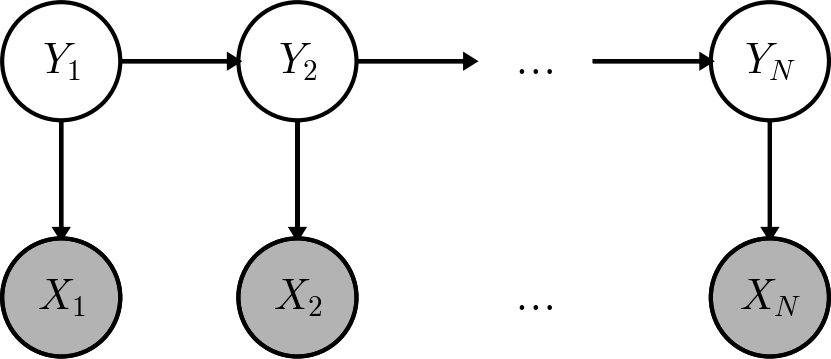

In [13]:
%%capture
pgm_hmm("images/hmm.png")

### Example:  Plate Notation

We can represent (conditionally) iid variables using **plate notation**.

In [14]:
@pgm_render
def pgm_plate_example():
    pgm = daft.PGM([4,3], origin=[-2,0], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("lambda", r"$\lambda$", -0.25, 2));
    
    pgm.add_node(daft.Node("t1", r"$\theta_1$", -1, 1.3));
    pgm.add_node(daft.Node("t2", r"$\theta_2$", -0.5, 1.3));
    pgm.add_node(daft.Node("dots1", r"$\cdots$",  0, 1.3, plot_params={ 'ec' : 'none' }));
    pgm.add_node(daft.Node("tN", r"$\theta_N$",  0.5, 1.3));
        
    pgm.add_node(daft.Node("x1", r"$X_1$", -1, 0.6));
    pgm.add_node(daft.Node("x2", r"$X_2$", -0.5, 0.6));
    pgm.add_node(daft.Node("dots2", r"$\cdots$",  0, 0.6, plot_params={ 'ec' : 'none' }));
    pgm.add_node(daft.Node("xN", r"$X_N$",  0.5, 0.6));
    
    
    pgm.add_node(daft.Node("LAMBDA", r"$\lambda$", 1.5, 2));
    pgm.add_node(daft.Node("THETA", r"$\theta_k$", 1.5,1.3));
    pgm.add_node(daft.Node("XX", r"$X_k$", 1.5,0.6));
    
    # edges
    pgm.add_edge("lambda", "t1", head_length=0.08);
    pgm.add_edge("lambda", "t2", head_length=0.08);
    pgm.add_edge("lambda", "tN", head_length=0.08);
    pgm.add_edge("t1", "x1", head_length=0.08);
    pgm.add_edge("t2", "x2", head_length=0.08);
    pgm.add_edge("tN", "xN", head_length=0.08);
    
    
    pgm.add_edge("LAMBDA", "THETA", head_length=0.08);
    pgm.add_edge("THETA", "XX", head_length=0.08);
    
    pgm.add_plate(daft.Plate([1.1,0.4,0.8,1.2], label=r"$\qquad\quad\; K$",
    shift=-0.1))
    
    return pgm;

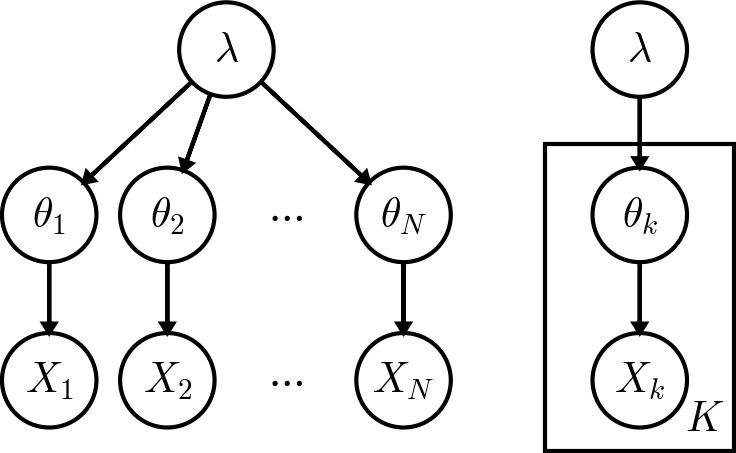

In [15]:
%%capture
pgm_plate_example("images/plate-example.png")